In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

## 1) Model Definition
- Define our generator -> UNet
- Define our discriminator -> 70x70 PatchGAN

In [21]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [22]:
'''
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
'''
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

def define_generator(image_shape=(256,256,3)):
  output_channels = 3

  # base model
  base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False)
  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
      'block_16_project',      # 4x4
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = True

  up_stack = [
      pix2pix.upsample(512, 3),  # 4x4 -> 8x8
      pix2pix.upsample(256, 3),  # 8x8 -> 16x16
      pix2pix.upsample(128, 3),  # 16x16 -> 32x32
      pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]

  # define the unet
  inputs = tf.keras.layers.Input(shape=image_shape)
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  out_image = Activation('tanh')(x)

  return Model(inputs=inputs, outputs=out_image)

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-b06fb8cb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-b06fb8cb
  Created wheel for tensorflow-examples: filename=tensorflow_examples-730a2ff0f72cbb8baf98daa7a676fe9b7a330ec4_-cp37-none-any.whl size=265844 sha256=70f760ab4bc1e5c853df5c9144e170138a69296e6e1745b948650f9fc5cd113e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s2kuwe_/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

## 1) Data Handling
- load_real_samples

In [13]:
# load and prepare training images
def load_real_samples(img_dir, mask_dir, starting_img_shape):
  # validate if the path name is correct
  assert os.path.isdir(img_dir), f"Directory does not exist: {img_dir}"
  assert os.path.isdir(mask_dir), f"Directory does not exist: {mask_dir}"
  
  # load images and masks
  print(f"Loading images and masks for: {img_dir[img_dir.rindex('/') + 1:]}")
  imgs = []
  masks = []

  # load all paths for mask
  mask_paths = os.listdir(mask_dir)

  # start looping
  for path in os.listdir(img_dir):
    # remove the path if it's a json file
    if path.endswith('.json'):
      _ = os.path.join(img_dir, path)
      os.remove(_)
      continue

    # check if the corresponding mask exist
    if path[:path.rindex('.')] + '_mask.jpg' in mask_paths:
      # read images
      _ = os.path.join(img_dir, path)
      img = plt.imread(_)
      img = cv2.resize(img, starting_img_shape)
      imgs.append(img)
      # read masks
      path = path[:path.rindex('.')] + '_mask.jpg'
      _ = os.path.join(mask_dir, path)
      mask = plt.imread(_)
      mask = cv2.resize(mask, starting_img_shape)
      masks.append(mask)
    else:
      print(f'Missing mask for {path}')

  # change into tensors
  imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
  masks = tf.convert_to_tensor(masks, dtype=tf.float32)
  masks = tf.expand_dims(masks, axis = -1)
  masks = tf.image.grayscale_to_rgb(masks)

  print()

	# scale from [0,255] to [-1,1]
  imgs = (imgs - 127.5) / 127.5
  masks = (masks - 127.5) / 127.5

  return [imgs, masks]

## 2) Training Utilities
- augmentation
- generate_real_samples
- generate_fake_samples
- summarize_performance
- train

In [14]:
# select a batch of random samples, returns images and target
def augmentation(img, mask, image_shape):
  # identify tensor shape
  r, c, ch = image_shape
  num = len(img)
  tensor_shape = (num, r, c, ch)

  # crop img (randomly)
  seeds = tf.random.uniform((1, 2), minval=0, maxval=100, dtype=tf.dtypes.int32, seed=None)
  aug_img = tf.image.stateless_random_crop(img, size=tensor_shape, seed=seeds[0], name=None)
  aug_mask = tf.image.stateless_random_crop(mask, size=tensor_shape, seed=seeds[0], name=None)

  # flip img (by chance)
  seeds = tf.random.uniform((1, 2), minval=0, maxval=100, dtype=tf.dtypes.int32, seed=None)
  aug_img = tf.image.stateless_random_flip_left_right(aug_img, seed=seeds[0])
  aug_mask = tf.image.stateless_random_flip_left_right(aug_mask, seed=seeds[0])

  # brightness
  aug_img = tf.image.random_brightness(aug_img, 0.2)

  # contrast
  aug_img = tf.image.random_contrast(aug_img, 0.5, 2.0)

  # saturation
  aug_img = tf.image.random_saturation(aug_img, 0.80, 1.20) #ori is 0.75-1.25

  # hue
  #aug_img = tf.image.random_hue(aug_img, 0.1)

  return aug_img, aug_mask

def generate_real_samples(dataset, n_samples, image_shape, patch_shape):
  # unpack dataset
  trainA, trainB = dataset
  # choose random instances
  ix = np.random.randint(0, trainA.shape[0], n_samples)
  # retrieve selected images
  # X1, X2 = trainA[ix], trainB[ix] (this one can use if dataset is numpy array)
  X1 = tf.gather(trainA, indices=ix)
  X2 = tf.gather(trainB, indices=ix)
  X1, X2 = augmentation(X1, X2, image_shape)
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
  # generate fake instance
  X = g_model.predict(samples)
  # create 'fake' class labels (0)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [15]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, image_shape, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, image_shape, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
  # save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  # save the generator model
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [16]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, image_shape=(256, 256, 3), n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, image_shape, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance every 5 epochs
		if (i+1) % (bat_per_epo * 5) == 0:
			summarize_performance(i, g_model, dataset, image_shape, n_samples=5)

## 3) Training

In [17]:
# root directory for images and masks
img_root_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition/New dataset/UTAR images'
mask_root_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition/New dataset/UTAR segmented'

# loaded image shape and actual image shape
loaded_img_shape = (300, 300)
image_shape = (256, 256, 3)

# list to contain imgs/masks tensors loaded from different folder
all_imgs = []
all_masks = []

# getting all imgs/masks
for video_name in os.listdir(mask_root_dir):
  img_dir = os.path.join(img_root_dir, video_name)
  mask_dir = os.path.join(mask_root_dir, video_name)
  imgs, masks = load_real_samples(img_dir, mask_dir, loaded_img_shape)
  all_imgs.append(imgs)
  all_masks.append(masks)

# generate the training dataset
train_dataset = [tf.concat(all_imgs, 0), tf.concat(all_masks, 0)]

# summary
print('Loaded', train_dataset[0].shape, train_dataset[1].shape)
print('\nTarget image size', image_shape)

Loading images and masks for: FAMILY MART_MY NEWS

Loading images and masks for: 99 SPEEDMART_TEALIVE

Loaded (186, 300, 300, 3) (186, 300, 300, 3)

Target image size (256, 256, 3)


In [18]:
def show_images(img):
  plt.imshow(img)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


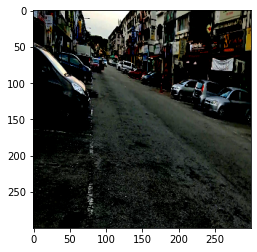

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


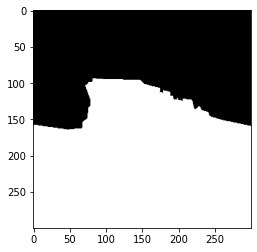

In [19]:
i = 150
show_images(train_dataset[0][i])
show_images(train_dataset[1][i])

In [24]:
# define the models
image_shape = (256, 256, 3)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

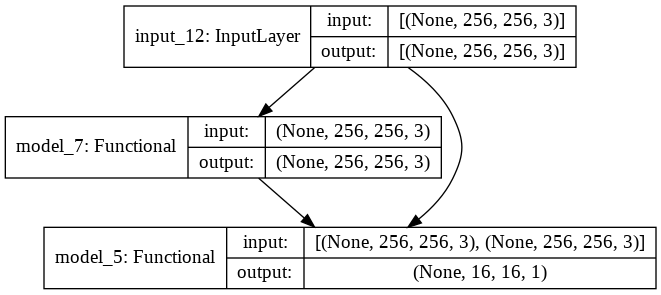

In [25]:
tf.keras.utils.plot_model(
    gan_model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [26]:
# train model
train(d_model, g_model, gan_model, train_dataset, image_shape)

>1, d1[0.581] d2[0.561] g[115.974]
>2, d1[0.563] d2[0.555] g[114.531]
>3, d1[0.659] d2[0.535] g[112.798]
>4, d1[0.648] d2[0.433] g[106.390]
>5, d1[0.740] d2[0.432] g[102.785]
>6, d1[0.478] d2[0.421] g[100.324]
>7, d1[0.409] d2[0.447] g[96.737]
>8, d1[0.430] d2[0.360] g[98.478]
>9, d1[0.410] d2[0.403] g[93.529]
>10, d1[0.386] d2[0.372] g[88.292]
>11, d1[0.277] d2[0.356] g[84.676]
>12, d1[0.212] d2[0.312] g[88.512]
>13, d1[0.277] d2[0.261] g[77.516]
>14, d1[0.230] d2[0.222] g[89.606]
>15, d1[0.280] d2[0.268] g[82.250]
>16, d1[0.188] d2[0.188] g[75.862]
>17, d1[0.163] d2[0.180] g[76.207]
>18, d1[0.140] d2[0.219] g[78.012]
>19, d1[0.107] d2[0.138] g[84.789]
>20, d1[0.219] d2[0.178] g[65.495]
>21, d1[0.137] d2[0.111] g[68.605]
>22, d1[0.098] d2[0.105] g[58.028]
>23, d1[0.049] d2[0.054] g[59.858]
>24, d1[0.058] d2[0.070] g[58.987]
>25, d1[0.512] d2[0.169] g[146.726]
>26, d1[0.095] d2[0.133] g[54.338]
>27, d1[0.134] d2[0.070] g[72.430]
>28, d1[0.070] d2[0.041] g[71.451]
>29, d1[0.185] d2[0.07

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: plot_000930.png and model_000930.h5
>931, d1[0.055] d2[0.105] g[2.557]
>932, d1[0.006] d2[0.052] g[3.275]
>933, d1[0.038] d2[0.028] g[3.187]
>934, d1[0.053] d2[0.023] g[7.547]
>935, d1[0.006] d2[0.027] g[2.207]
>936, d1[0.005] d2[0.041] g[2.263]
>937, d1[0.061] d2[0.149] g[6.626]
>938, d1[0.005] d2[0.045] g[4.762]
>939, d1[0.035] d2[0.080] g[10.505]
>940, d1[0.008] d2[0.033] g[2.404]
>941, d1[0.040] d2[0.109] g[17.169]
>942, d1[0.006] d2[0.026] g[2.499]
>943, d1[0.012] d2[0.025] g[2.910]
>944, d1[0.008] d2[0.243] g[2.214]
>945, d1[0.039] d2[0.472] g[6.697]
>946, d1[0.323] d2[0.052] g[6.166]
>947, d1[0.498] d2[0.136] g[9.449]
>948, d1[1.354] d2[0.174] g[12.552]
>949, d1[0.621] d2[0.391] g[5.628]
>950, d1[0.455] d2[0.838] g[3.655]
>951, d1[0.393] d2[0.611] g[15.393]
>952, d1[0.668] d2[0.326] g[6.379]
>953, d1[0.441] d2[0.407] g[4.566]
>954, d1[0.276] d2[0.167] g[2.794]
>955, d1[0.270] d2[0.199] g[3.258]
>956, d1[0.104] d2[1.102] g[6.301]
>957, d1[0.066] d2[0.098] g[4.275]
>958, d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1859, d1[0.118] d2[0.447] g[5.654]
>1860, d1[0.609] d2[0.076] g[4.490]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_001860.png and model_001860.h5
>1861, d1[0.034] d2[0.115] g[1.973]
>1862, d1[0.020] d2[0.116] g[3.477]
>1863, d1[0.020] d2[0.539] g[6.775]
>1864, d1[0.053] d2[0.130] g[3.112]
>1865, d1[0.058] d2[0.017] g[8.325]
>1866, d1[0.081] d2[0.035] g[4.629]
>1867, d1[0.023] d2[0.123] g[3.953]
>1868, d1[0.072] d2[0.060] g[4.825]
>1869, d1[0.035] d2[0.297] g[5.707]
>1870, d1[0.061] d2[0.039] g[5.863]
>1871, d1[0.369] d2[0.234] g[8.376]
>1872, d1[0.062] d2[0.059] g[5.411]
>1873, d1[0.030] d2[0.025] g[74.659]
>1874, d1[0.028] d2[0.040] g[8.512]
>1875, d1[0.032] d2[0.058] g[1.746]
>1876, d1[0.030] d2[0.036] g[3.817]
>1877, d1[0.025] d2[0.059] g[5.535]
>1878, d1[0.014] d2[0.292] g[1.287]
>1879, d1[0.037] d2[0.102] g[2.421]
>1880, d1[0.139] d2[0.216] g[2.840]
>1881, d1[0.073] d2[0.048] g[3.374]
>1882, d1[0.065] d2[0.107] g[4.878]
>1883, d1[0.116] d2[0.087] g[1.847]
>1884, d1[0.038] d2[0.402] g[7.334]
>1885, d1[0.223] d2[0.771] g[33.439]
>1886, d1[0.400] d2[0.138] g[2.021]
>1887, d1[0.388] d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2790, d1[0.270] d2[0.093] g[3.630]
>Saved: plot_002790.png and model_002790.h5
>2791, d1[0.290] d2[0.133] g[13.599]
>2792, d1[0.098] d2[0.938] g[3.070]
>2793, d1[0.310] d2[0.112] g[2.683]
>2794, d1[0.177] d2[0.327] g[3.485]
>2795, d1[0.516] d2[0.185] g[4.050]
>2796, d1[0.147] d2[0.215] g[3.347]
>2797, d1[0.147] d2[0.043] g[9.517]
>2798, d1[0.089] d2[0.177] g[4.627]
>2799, d1[0.177] d2[0.049] g[7.851]
>2800, d1[0.130] d2[0.047] g[8.995]
>2801, d1[0.032] d2[0.152] g[1.399]
>2802, d1[0.033] d2[0.116] g[4.367]
>2803, d1[0.054] d2[0.045] g[13.090]
>2804, d1[0.031] d2[0.077] g[1.923]
>2805, d1[0.033] d2[0.066] g[2.022]
>2806, d1[0.048] d2[0.051] g[3.721]
>2807, d1[0.031] d2[0.044] g[8.436]
>2808, d1[0.024] d2[0.030] g[5.586]
>2809, d1[0.021] d2[0.059] g[3.414]
>2810, d1[0.022] d2[0.034] g[2.385]
>2811, d1[0.020] d2[0.057] g[1.445]
>2812, d1[0.028] d2[0.555] g[3.316]
>2813, d1[0.179] d2[0.087] g[5.302]
>2814, d1[0.056] d2[0.037] g[4.745]
>2815, d1[0.070] d2[0.281] g[8.195]
>2816, d1[0.884] d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3720, d1[0.267] d2[0.237] g[4.630]
>Saved: plot_003720.png and model_003720.h5
>3721, d1[0.099] d2[0.147] g[4.101]
>3722, d1[0.133] d2[0.152] g[7.085]
>3723, d1[0.078] d2[0.360] g[3.654]
>3724, d1[0.174] d2[0.209] g[4.216]
>3725, d1[0.100] d2[0.112] g[7.270]
>3726, d1[0.226] d2[0.104] g[5.218]
>3727, d1[0.273] d2[0.087] g[33.270]
>3728, d1[0.045] d2[0.050] g[7.092]
>3729, d1[0.040] d2[0.189] g[7.579]
>3730, d1[0.029] d2[0.554] g[3.975]
>3731, d1[0.159] d2[0.369] g[15.285]
>3732, d1[0.234] d2[0.248] g[4.507]
>3733, d1[0.640] d2[0.215] g[12.233]
>3734, d1[0.111] d2[0.513] g[3.568]
>3735, d1[0.191] d2[0.166] g[3.253]
>3736, d1[0.092] d2[0.538] g[2.721]
>3737, d1[0.759] d2[0.060] g[4.618]
>3738, d1[0.119] d2[0.095] g[1.613]
>3739, d1[0.053] d2[0.112] g[5.009]
>3740, d1[0.044] d2[0.424] g[4.175]
>3741, d1[0.683] d2[0.162] g[1.559]
>3742, d1[0.121] d2[0.085] g[8.268]
>3743, d1[0.054] d2[0.145] g[2.570]
>3744, d1[0.099] d2[0.076] g[8.229]
>3745, d1[0.113] d2[0.438] g[1.629]
>3746, d1[0.072] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_004650.png and model_004650.h5
>4651, d1[0.048] d2[0.206] g[2.352]
>4652, d1[0.111] d2[0.771] g[6.755]
>4653, d1[0.293] d2[0.138] g[3.503]
>4654, d1[0.362] d2[0.229] g[3.956]
>4655, d1[0.107] d2[0.285] g[3.229]
>4656, d1[0.058] d2[0.122] g[36.272]
>4657, d1[0.134] d2[0.299] g[2.501]
>4658, d1[0.127] d2[0.242] g[4.132]
>4659, d1[0.417] d2[0.075] g[8.479]
>4660, d1[0.060] d2[0.411] g[2.680]
>4661, d1[0.174] d2[0.152] g[15.326]
>4662, d1[0.199] d2[0.277] g[2.126]
>4663, d1[0.113] d2[0.303] g[8.777]
>4664, d1[0.260] d2[0.078] g[12.581]
>4665, d1[0.164] d2[0.076] g[3.145]
>4666, d1[0.285] d2[0.083] g[5.446]
>4667, d1[0.031] d2[0.912] g[4.159]
>4668, d1[0.128] d2[0.644] g[4.759]
>4669, d1[0.774] d2[0.068] g[4.568]
>4670, d1[0.545] d2[0.288] g[5.255]
>4671, d1[0.359] d2[0.380] g[3.447]
>4672, d1[0.424] d2[0.297] g[2.745]
>4673, d1[0.295] d2[0.202] g[4.608]
>4674, d1[0.156] d2[0.190] g[1.979]
>4675, d1[0.252] d2[0.236] g[5.338]
>4676, d1[0.138] d2[0.140] g[4.497]
>4677, d1[0.049] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_005580.png and model_005580.h5
>5581, d1[0.407] d2[0.060] g[4.248]
>5582, d1[0.023] d2[0.796] g[1.996]
>5583, d1[0.042] d2[0.042] g[4.063]
>5584, d1[0.351] d2[0.027] g[7.262]
>5585, d1[0.188] d2[1.419] g[3.896]
>5586, d1[0.180] d2[0.457] g[3.156]
>5587, d1[0.345] d2[0.061] g[4.880]
>5588, d1[0.453] d2[0.148] g[4.723]
>5589, d1[0.392] d2[0.555] g[3.780]
>5590, d1[0.193] d2[0.253] g[6.997]
>5591, d1[0.122] d2[0.200] g[4.739]
>5592, d1[0.160] d2[0.223] g[5.628]
>5593, d1[0.385] d2[0.147] g[9.518]
>5594, d1[0.098] d2[0.277] g[1.751]
>5595, d1[0.176] d2[0.137] g[5.047]
>5596, d1[0.057] d2[0.205] g[1.941]
>5597, d1[0.037] d2[0.101] g[8.912]
>5598, d1[0.099] d2[0.123] g[5.211]
>5599, d1[0.069] d2[0.154] g[2.781]
>5600, d1[0.304] d2[0.057] g[5.908]
>5601, d1[0.033] d2[0.064] g[1.221]
>5602, d1[0.056] d2[0.528] g[7.041]
>5603, d1[0.122] d2[0.405] g[3.703]
>5604, d1[1.127] d2[0.037] g[6.955]
>5605, d1[0.314] d2[0.258] g[5.939]
>5606, d1[0.079] d2[0.042] g[7.278]
>5607, d1[0.830] d2[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6509, d1[0.385] d2[0.204] g[7.287]
>6510, d1[0.459] d2[0.082] g[3.530]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_006510.png and model_006510.h5
>6511, d1[0.111] d2[0.871] g[3.299]
>6512, d1[0.142] d2[0.344] g[4.791]
>6513, d1[0.174] d2[0.421] g[3.135]
>6514, d1[0.747] d2[0.175] g[6.596]
>6515, d1[0.265] d2[0.172] g[3.929]
>6516, d1[0.227] d2[0.089] g[2.535]
>6517, d1[0.325] d2[0.329] g[15.303]
>6518, d1[0.240] d2[0.863] g[2.588]
>6519, d1[0.051] d2[0.411] g[3.680]
>6520, d1[0.425] d2[0.188] g[10.581]
>6521, d1[0.286] d2[0.071] g[9.969]
>6522, d1[0.201] d2[0.072] g[2.859]
>6523, d1[0.041] d2[0.591] g[5.259]
>6524, d1[0.067] d2[0.085] g[9.150]
>6525, d1[0.050] d2[0.594] g[8.269]
>6526, d1[0.195] d2[0.279] g[2.038]
>6527, d1[0.735] d2[0.262] g[7.960]
>6528, d1[0.217] d2[0.068] g[2.203]
>6529, d1[0.288] d2[0.486] g[9.025]
>6530, d1[0.087] d2[0.081] g[4.895]
>6531, d1[0.181] d2[0.329] g[2.544]
>6532, d1[0.047] d2[0.436] g[4.345]
>6533, d1[0.581] d2[0.134] g[2.668]
>6534, d1[0.271] d2[0.060] g[11.475]
>6535, d1[0.160] d2[0.375] g[3.313]
>6536, d1[0.055] d2[0.366] g[2.701]
>6537, d1[0.388] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8369, d1[0.028] d2[0.066] g[12.847]
>8370, d1[0.351] d2[0.091] g[6.998]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_008370.png and model_008370.h5
>8371, d1[0.016] d2[0.983] g[7.699]
>8372, d1[0.343] d2[0.091] g[3.040]
>8373, d1[0.362] d2[0.255] g[4.952]
>8374, d1[0.033] d2[0.909] g[4.293]
>8375, d1[0.623] d2[0.091] g[5.893]
>8376, d1[0.212] d2[0.131] g[4.547]
>8377, d1[0.658] d2[0.067] g[3.393]
>8378, d1[0.497] d2[1.543] g[2.142]
>8379, d1[0.404] d2[0.369] g[3.984]
>8380, d1[0.337] d2[0.411] g[6.935]
>8381, d1[0.572] d2[0.255] g[2.549]
>8382, d1[0.344] d2[0.531] g[3.624]
>8383, d1[0.317] d2[0.395] g[4.204]
>8384, d1[0.345] d2[0.290] g[2.721]
>8385, d1[0.323] d2[0.446] g[3.599]
>8386, d1[0.427] d2[0.258] g[2.728]
>8387, d1[0.344] d2[0.316] g[7.999]
>8388, d1[0.382] d2[0.393] g[1.170]
>8389, d1[0.311] d2[0.402] g[2.707]
>8390, d1[0.273] d2[0.221] g[16.225]
>8391, d1[0.524] d2[0.144] g[16.009]
>8392, d1[0.156] d2[0.302] g[3.943]
>8393, d1[0.138] d2[0.172] g[3.499]
>8394, d1[0.187] d2[0.277] g[5.501]
>8395, d1[0.158] d2[0.417] g[6.842]
>8396, d1[0.122] d2[0.414] g[5.075]
>8397, d1[0.601] d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9300, d1[0.401] d2[0.249] g[3.192]
>Saved: plot_009300.png and model_009300.h5
>9301, d1[0.127] d2[0.080] g[8.184]
>9302, d1[0.160] d2[0.336] g[2.069]
>9303, d1[0.344] d2[0.338] g[4.228]
>9304, d1[0.016] d2[0.335] g[2.691]
>9305, d1[0.140] d2[0.170] g[4.974]
>9306, d1[0.198] d2[0.124] g[9.228]
>9307, d1[0.262] d2[0.219] g[2.430]
>9308, d1[0.371] d2[0.143] g[2.165]
>9309, d1[0.065] d2[0.125] g[8.535]
>9310, d1[0.132] d2[0.345] g[2.492]
>9311, d1[0.025] d2[0.392] g[3.407]
>9312, d1[0.567] d2[0.157] g[7.600]
>9313, d1[0.164] d2[0.259] g[6.807]
>9314, d1[0.151] d2[0.174] g[6.645]
>9315, d1[0.222] d2[0.089] g[3.519]
>9316, d1[0.066] d2[0.292] g[3.841]
>9317, d1[0.188] d2[0.222] g[3.172]
>9318, d1[0.162] d2[0.176] g[1.870]
>9319, d1[0.198] d2[0.514] g[3.213]
>9320, d1[0.048] d2[0.080] g[6.396]
>9321, d1[0.144] d2[0.167] g[2.330]
>9322, d1[0.052] d2[0.383] g[5.932]
>9323, d1[0.174] d2[0.066] g[3.721]
>9324, d1[0.028] d2[0.043] g[1.951]
>9325, d1[0.426] d2[0.053] g[3.907]
>9326, d1[0.042] d2[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12089, d1[0.036] d2[1.488] g[1.968]
>12090, d1[0.327] d2[0.095] g[2.029]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_012090.png and model_012090.h5
>12091, d1[0.531] d2[0.302] g[3.881]
>12092, d1[0.482] d2[0.381] g[3.319]
>12093, d1[0.232] d2[0.717] g[7.798]
>12094, d1[0.423] d2[0.110] g[4.459]
>12095, d1[0.360] d2[0.163] g[4.139]
>12096, d1[0.230] d2[0.166] g[3.720]
>12097, d1[0.118] d2[0.304] g[2.189]
>12098, d1[0.118] d2[0.130] g[4.418]
>12099, d1[0.206] d2[0.318] g[5.053]
>12100, d1[0.142] d2[0.265] g[3.601]
>12101, d1[0.099] d2[0.403] g[2.855]
>12102, d1[0.442] d2[0.100] g[3.781]
>12103, d1[0.161] d2[0.154] g[5.376]
>12104, d1[0.286] d2[0.158] g[4.100]
>12105, d1[0.140] d2[0.245] g[2.965]
>12106, d1[0.036] d2[0.148] g[4.859]
>12107, d1[0.059] d2[0.186] g[3.489]
>12108, d1[0.039] d2[0.374] g[3.883]
>12109, d1[0.134] d2[0.117] g[3.958]
>12110, d1[0.345] d2[0.170] g[3.701]
>12111, d1[0.125] d2[0.512] g[3.296]
>12112, d1[0.139] d2[0.144] g[3.459]
>12113, d1[0.255] d2[0.287] g[1.736]
>12114, d1[0.019] d2[0.135] g[3.093]
>12115, d1[0.236] d2[0.203] g[5.088]
>12116, d1[0.436] d2[0.428] g[3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13020, d1[0.058] d2[0.280] g[2.682]
>Saved: plot_013020.png and model_013020.h5
>13021, d1[0.672] d2[0.096] g[5.787]
>13022, d1[0.225] d2[0.372] g[2.031]
>13023, d1[0.133] d2[0.142] g[3.954]
>13024, d1[0.044] d2[0.057] g[3.766]
>13025, d1[0.245] d2[0.194] g[1.073]
>13026, d1[0.019] d2[0.125] g[5.051]
>13027, d1[0.088] d2[0.858] g[5.530]
>13028, d1[0.464] d2[0.040] g[5.779]
>13029, d1[0.169] d2[0.074] g[2.648]
>13030, d1[0.022] d2[0.120] g[4.821]
>13031, d1[0.039] d2[0.323] g[3.301]
>13032, d1[0.525] d2[0.064] g[5.922]
>13033, d1[0.204] d2[0.100] g[4.707]
>13034, d1[0.031] d2[0.047] g[5.396]
>13035, d1[0.020] d2[0.556] g[5.591]
>13036, d1[0.118] d2[0.063] g[2.987]
>13037, d1[0.383] d2[0.247] g[6.620]
>13038, d1[0.047] d2[0.073] g[3.418]
>13039, d1[0.240] d2[0.057] g[7.596]
>13040, d1[0.012] d2[0.164] g[2.891]
>13041, d1[0.105] d2[0.333] g[2.200]
>13042, d1[0.240] d2[0.053] g[4.959]
>13043, d1[0.036] d2[0.119] g[9.807]
>13044, d1[0.013] d2[1.728] g[2.205]
>13045, d1[0.305] d2[0.158] g[3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13949, d1[0.081] d2[0.377] g[6.030]
>13950, d1[0.075] d2[0.126] g[2.472]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_013950.png and model_013950.h5
>13951, d1[0.610] d2[0.066] g[9.276]
>13952, d1[0.215] d2[0.056] g[3.217]
>13953, d1[0.062] d2[0.071] g[4.295]
>13954, d1[0.014] d2[1.537] g[3.690]
>13955, d1[0.023] d2[0.064] g[4.513]
>13956, d1[0.123] d2[0.054] g[6.179]
>13957, d1[0.160] d2[0.548] g[2.225]
>13958, d1[0.080] d2[0.048] g[3.354]
>13959, d1[0.294] d2[0.779] g[1.714]
>13960, d1[0.185] d2[0.042] g[8.284]
>13961, d1[0.273] d2[0.137] g[5.186]
>13962, d1[0.183] d2[0.713] g[2.009]
>13963, d1[0.116] d2[0.049] g[6.129]
>13964, d1[0.523] d2[0.275] g[2.560]
>13965, d1[0.730] d2[0.083] g[2.913]
>13966, d1[0.038] d2[0.666] g[3.974]
>13967, d1[0.108] d2[0.044] g[4.284]
>13968, d1[0.353] d2[0.318] g[1.764]
>13969, d1[0.200] d2[0.638] g[3.089]
>13970, d1[0.178] d2[0.346] g[2.643]
>13971, d1[1.009] d2[0.094] g[2.646]
>13972, d1[0.616] d2[0.570] g[2.427]
>13973, d1[0.179] d2[0.237] g[2.525]
>13974, d1[0.528] d2[0.139] g[2.142]
>13975, d1[0.119] d2[0.251] g[2.709]
>13976, d1[0.157] d2[0.313] g[3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14880, d1[0.036] d2[0.327] g[2.705]
>Saved: plot_014880.png and model_014880.h5
>14881, d1[0.332] d2[0.062] g[6.246]
>14882, d1[0.037] d2[0.194] g[5.724]
>14883, d1[0.089] d2[0.125] g[3.420]
>14884, d1[0.076] d2[0.359] g[4.547]
>14885, d1[0.262] d2[0.105] g[5.328]
>14886, d1[0.100] d2[0.388] g[5.753]
>14887, d1[0.120] d2[0.116] g[4.747]
>14888, d1[0.138] d2[0.665] g[1.469]
>14889, d1[0.276] d2[0.093] g[4.030]
>14890, d1[0.134] d2[0.060] g[2.969]
>14891, d1[0.088] d2[0.473] g[6.736]
>14892, d1[0.277] d2[0.109] g[4.307]
>14893, d1[0.241] d2[0.175] g[6.858]
>14894, d1[0.051] d2[0.212] g[8.411]
>14895, d1[0.061] d2[0.265] g[2.992]
>14896, d1[0.015] d2[1.383] g[4.092]
>14897, d1[1.098] d2[0.077] g[23.322]
>14898, d1[1.189] d2[0.068] g[4.959]
>14899, d1[0.826] d2[0.186] g[2.274]
>14900, d1[0.712] d2[0.224] g[8.129]
>14901, d1[0.426] d2[0.390] g[9.429]
>14902, d1[0.501] d2[0.324] g[5.484]
>14903, d1[0.673] d2[0.171] g[5.291]
>14904, d1[0.400] d2[0.387] g[4.225]
>14905, d1[0.458] d2[0.307] g[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15809, d1[0.007] d2[0.903] g[6.432]
>15810, d1[0.120] d2[0.089] g[4.153]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_015810.png and model_015810.h5
>15811, d1[0.017] d2[0.027] g[4.635]
>15812, d1[0.162] d2[0.049] g[5.859]
>15813, d1[0.235] d2[0.044] g[10.696]
>15814, d1[0.018] d2[0.271] g[6.204]
>15815, d1[0.013] d2[0.065] g[6.136]
>15816, d1[0.143] d2[0.046] g[4.743]
>15817, d1[0.027] d2[0.079] g[3.442]
>15818, d1[0.164] d2[0.137] g[7.603]
>15819, d1[0.021] d2[0.404] g[4.234]
>15820, d1[0.034] d2[0.039] g[6.029]
>15821, d1[0.361] d2[0.228] g[3.150]
>15822, d1[0.047] d2[0.118] g[3.561]
>15823, d1[0.023] d2[0.458] g[7.801]
>15824, d1[0.100] d2[0.043] g[4.081]
>15825, d1[0.045] d2[0.036] g[1.674]
>15826, d1[0.097] d2[0.057] g[4.338]
>15827, d1[0.111] d2[0.137] g[3.357]
>15828, d1[0.638] d2[0.557] g[3.722]
>15829, d1[0.253] d2[0.087] g[2.861]
>15830, d1[0.065] d2[1.182] g[3.510]
>15831, d1[0.371] d2[0.066] g[9.207]
>15832, d1[0.112] d2[0.192] g[5.770]
>15833, d1[0.436] d2[0.051] g[12.369]
>15834, d1[0.044] d2[0.079] g[6.441]
>15835, d1[0.015] d2[0.075] g[1.610]
>15836, d1[0.026] d2[1.541] g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>16740, d1[0.148] d2[0.095] g[1.467]
>Saved: plot_016740.png and model_016740.h5
>16741, d1[0.150] d2[0.212] g[5.900]
>16742, d1[0.031] d2[0.231] g[2.681]
>16743, d1[0.256] d2[0.203] g[2.242]
>16744, d1[0.070] d2[0.275] g[3.651]
>16745, d1[0.108] d2[0.095] g[3.456]
>16746, d1[0.719] d2[0.082] g[5.028]
>16747, d1[0.086] d2[0.305] g[3.493]
>16748, d1[0.063] d2[0.291] g[2.685]
>16749, d1[0.107] d2[0.417] g[6.787]
>16750, d1[0.137] d2[0.653] g[3.281]
>16751, d1[1.053] d2[0.109] g[4.600]
>16752, d1[0.822] d2[0.147] g[9.771]
>16753, d1[0.666] d2[0.241] g[2.866]
>16754, d1[0.644] d2[0.218] g[3.977]
>16755, d1[0.677] d2[0.190] g[3.108]
>16756, d1[0.332] d2[0.400] g[3.209]
>16757, d1[0.418] d2[0.395] g[4.077]
>16758, d1[0.253] d2[0.395] g[2.762]
>16759, d1[0.331] d2[0.424] g[4.956]
>16760, d1[0.380] d2[0.276] g[3.227]
>16761, d1[0.561] d2[0.209] g[4.745]
>16762, d1[0.304] d2[0.457] g[2.590]
>16763, d1[0.356] d2[0.235] g[4.430]
>16764, d1[0.100] d2[0.433] g[6.953]
>16765, d1[0.204] d2[0.298] g[3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>17670, d1[0.592] d2[0.199] g[5.019]
>Saved: plot_017670.png and model_017670.h5
>17671, d1[0.394] d2[0.066] g[3.671]
>17672, d1[0.016] d2[0.363] g[1.021]
>17673, d1[0.019] d2[0.127] g[3.906]
>17674, d1[0.060] d2[0.168] g[3.588]
>17675, d1[0.264] d2[0.144] g[3.134]
>17676, d1[0.032] d2[0.441] g[1.623]
>17677, d1[0.107] d2[0.117] g[3.553]
>17678, d1[0.150] d2[0.085] g[6.328]
>17679, d1[0.182] d2[0.166] g[2.282]
>17680, d1[0.024] d2[0.452] g[11.795]
>17681, d1[0.237] d2[0.391] g[3.399]
>17682, d1[0.238] d2[0.059] g[3.182]
>17683, d1[0.252] d2[0.086] g[3.279]
>17684, d1[0.020] d2[0.375] g[2.007]
>17685, d1[0.293] d2[0.051] g[3.642]
>17686, d1[0.059] d2[0.183] g[1.897]
>17687, d1[0.093] d2[0.065] g[3.931]
>17688, d1[0.119] d2[0.577] g[4.696]
>17689, d1[0.372] d2[0.068] g[5.579]
>17690, d1[0.112] d2[0.334] g[3.437]
>17691, d1[0.289] d2[0.108] g[2.057]
>17692, d1[0.637] d2[0.167] g[4.292]
>17693, d1[0.762] d2[0.092] g[5.321]
>17694, d1[0.075] d2[0.329] g[0.913]
>17695, d1[0.013] d2[0.596] g[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18599, d1[0.291] d2[0.154] g[3.397]
>18600, d1[0.092] d2[0.200] g[3.116]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_018600.png and model_018600.h5


In [32]:
test_img_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition/New dataset/UTAR images/KK MART_7 ELEVEN'
test_mask_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition/New dataset/UTAR segmented/FAMILY MART_MY NEWS' #dummy
test_dataset = load_real_samples(test_img_dir, test_mask_dir, (300, 300))

Loading images and masks for: KK MART_7 ELEVEN



In [37]:
summarize_performance(0, g_model, test_dataset, image_shape, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_000001.png and model_000001.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [39]:
model = tf.keras.models.load_model('/content/model_018600.h5', compile=False)
for layer in model.layers:
  layer.trainable = False

In [40]:
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

#path of the directory where you want to save your model
frozen_out_path = r'/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition'
# name of the .pb file
frozen_graph_filename = 'frozen_graph'
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

------------------------------------------------------------
Frozen model layers: 
x
model_7/model_6/Conv1/Conv2D/ReadVariableOp/resource
model_7/model_6/Conv1/Conv2D/ReadVariableOp
model_7/model_6/Conv1/Conv2D
model_7/model_6/bn_Conv1/ReadVariableOp/resource
model_7/model_6/bn_Conv1/ReadVariableOp
model_7/model_6/bn_Conv1/ReadVariableOp_1/resource
model_7/model_6/bn_Conv1/ReadVariableOp_1
model_7/model_6/bn_Conv1/FusedBatchNormV3/ReadVariableOp/resource
model_7/model_6/bn_Conv1/FusedBatchNormV3/ReadVariableOp
model_7/model_6/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1/resource
model_7/model_6/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1
model_7/model_6/bn_Conv1/FusedBatchNormV3
model_7/model_6/Conv1_relu/Relu6
model_7/model_6/expanded_conv_depthwise/depthwise/ReadVariableOp/resource
model_7/model_6/expanded_conv_depthwise/depthwise/ReadVariableOp
model_7/model_6/expanded_conv_depthwise/depthwise
model_7/model_6/expanded_conv_depthwise_BN/ReadVariableOp/resource
model_7/model_6/expanded_c

'/content/drive/MyDrive/Colab Notebooks/OpenCV AI Competition/frozen_graph.pbtxt'

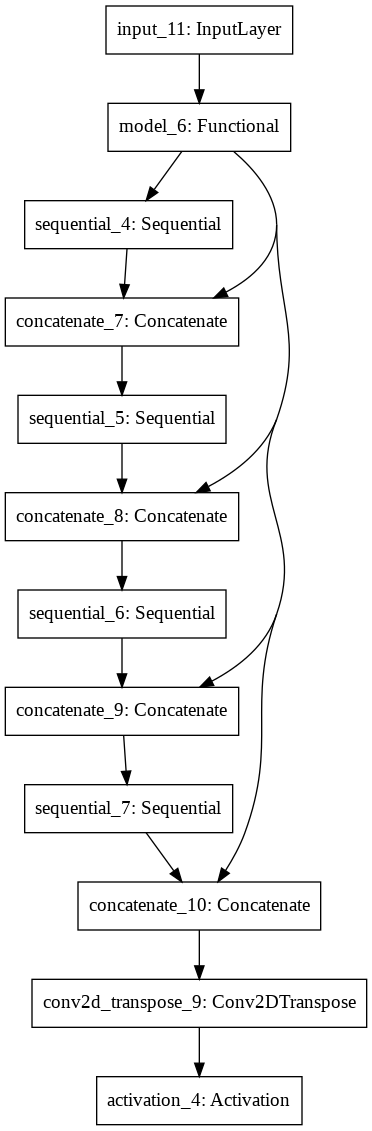

In [43]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)